In [2]:
import torch
import os
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

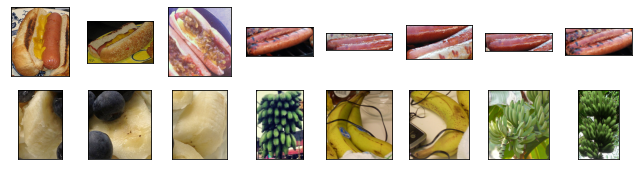

In [4]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

In [5]:
# 使用三个RGB通道的均值和标准差，标准化每个通道
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])


In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\18728/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth
100.0%


Linear(in_features=512, out_features=1000, bias=True)

In [7]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0719, -0.0541,  0.0605,  ...,  0.0145, -0.0217,  0.0087],
        [ 0.0507,  0.0868,  0.1048,  ..., -0.0781, -0.0051, -0.0769]],
       requires_grad=True)

In [ ]:
# 使用微调的训练函数
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),transforms=train_augs),
    batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),transforms=test_augs),
    batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        param_1x = [
            param for name, param in net.named_parameters() if name not in ['fc.weight', 'fc.bias']
        ]
        trainer = torch.optim.SGD([{
            'params': param_1x},
            {
            'params': net.fc.parameters(),
            'lr': learning_rate*10
        }], lr = learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
        d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [15]:
train_fine_tuning(finetune_net, 5e-5)

16658.6